In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [2]:
PYTHON_PATHS = ["../.."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        

from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
from imap.data.datasets.tum.tum_dataset_loader_factory import TUMDatasetLoaderFactory
from imap.model.nerf import NERF
from imap.model.embeddings.gaussian_positional_encoding import GaussianPositionalEncoding
from imap.model.embeddings.gaussian_positional_embedding import GaussianPositionalEmbedding
from imap.trainers.trainers import ModelTrainer
from imap.model.active_sampling.image_active_sampling import ImageActiveSampling
from imap.utils.utils import *

from imap.utils.image_renderer import ImageRenderer
from imap.utils.visualization.plot_trajectories import plot_trajectories

# Track a few images

### Train on 1 image

In [3]:

dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(0,573,10)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [4]:
model_parameters = AttributeDict(
    name="NERF",
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    minimal_depth=0.01,
    positional_embedding = AttributeDict(
                                        name = 'GaussianPositionalEmbedding',
                                        encoding_dimension=93,
                                        sigma=25,
                                        use_only_sin=False,
                                        use_bias=True
                                        )
)

factory = UniversalFactory([NERF, GaussianPositionalEncoding, GaussianPositionalEmbedding])
model = factory.make_from_parameters(model_parameters, camera_info=camera)

In [5]:
model.cuda()
model.train()

image_active_sampler = ImageActiveSampling(camera, points_per_frame=200)
trainer = ModelTrainer(image_active_sampler)

trainer.train_model(model, dataset_loader, 300, is_image_active_sampling=True)

  0%|          | 0/300 [00:00<?, ?it/s]

In [6]:
# model.eval()
# color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images = render_images(model, camera, dataset_loader)

image_renderer = ImageRenderer(camera)
model.eval()
color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images = [], [], [], []
i=10
for state in dataset_loader:

    position_to_render = state.get_matrix_position().to('cuda')
    
    color_coarse_image, depth_coarse_image, color_fine_image, depth_fine_image = image_renderer.render_output(model, position_to_render)
    color_coarse_images.append(color_coarse_image)
    depth_coarse_images.append(depth_coarse_image)
    color_fine_images.append(color_fine_image)
    depth_fine_images.append(depth_fine_image)
    i -=1
    if i <0:
        break

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


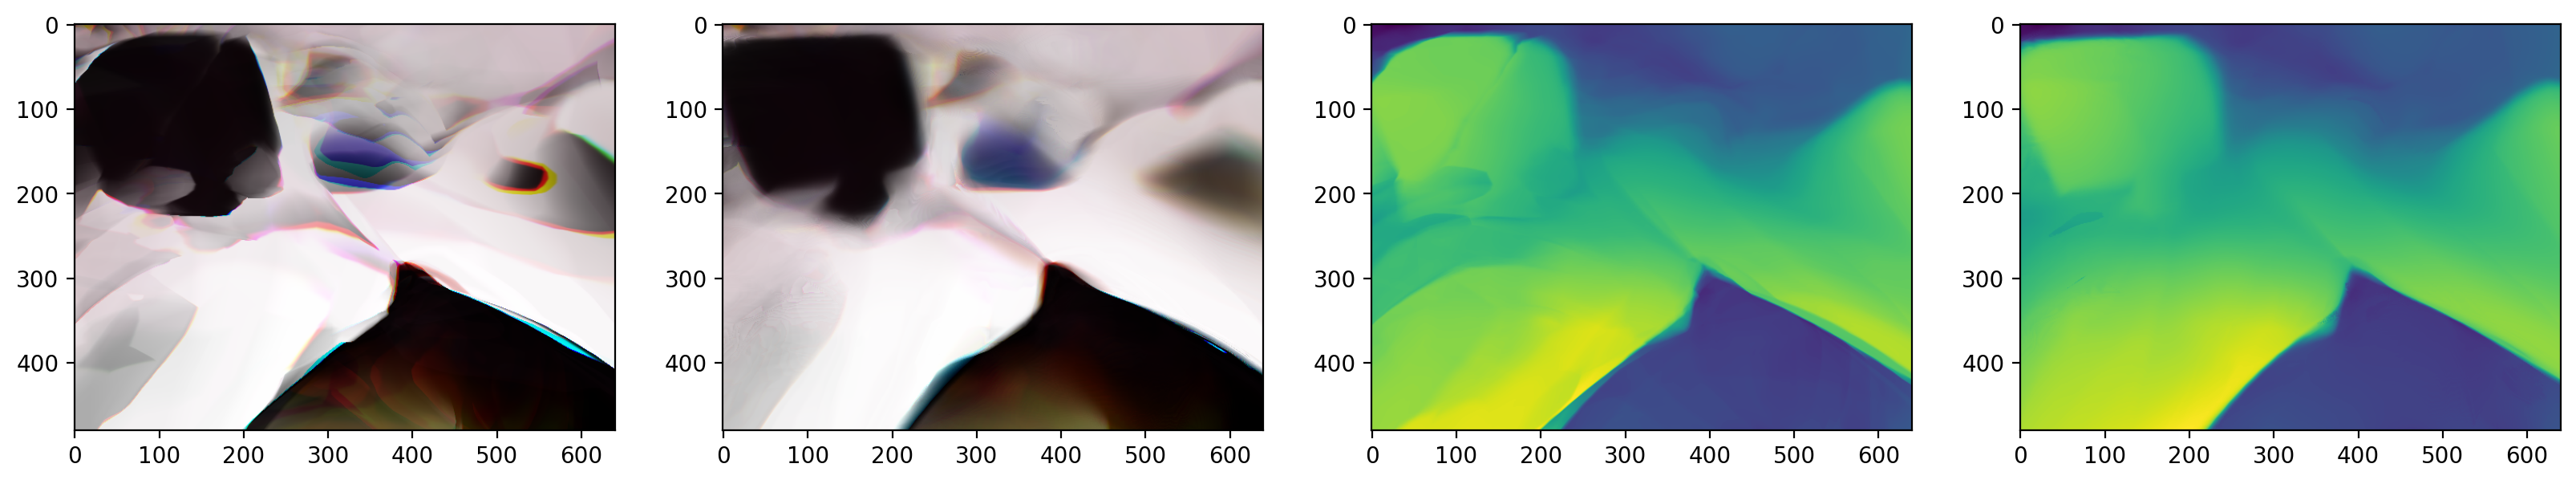

In [28]:
indx = 0
figure = plt.figure(dpi=200, figsize=(20,18))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(color_coarse_images[indx], cv2.COLOR_RGB2BGR))


plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(color_fine_images[indx], cv2.COLOR_RGB2BGR))

plt.subplot(1,4,3)
plt.imshow(1. /depth_coarse_images[indx])


plt.subplot(1,4,4)
plt.imshow(1. /depth_fine_images[indx])

### Tracking

In [8]:
dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(573)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, tracking_dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [9]:
poses = trainer.localization(model, tracking_dataset_loader)

  0%|          | 0/573 [00:00<?, ?it/s]

In [15]:
gt_poses = []
for state in tracking_dataset_loader:
    gt_poses.append(state.get_matrix_position().numpy())
np.array(gt_poses)[:, 3, :3]

array([[ 0.13112001,  0.08507001,  0.15186   ],
       [ 0.13190001,  0.08445998,  0.15203   ],
       [ 0.13263002,  0.08375   ,  0.15226   ],
       ...,
       [ 0.09458999, -0.00047   ,  0.12874   ],
       [ 0.09454001, -0.00042   ,  0.12881999],
       [ 0.09453   , -0.00038   ,  0.12888001]], dtype=float32)

In [16]:
np.array(poses)[:, 3, :3]

array([[ 0.1292395 ,  0.08434127,  0.15094848],
       [ 0.12893234,  0.08433323,  0.15264978],
       [ 0.13340986,  0.08162168,  0.15292846],
       ...,
       [ 0.07501191, -0.4288084 ,  0.29559544],
       [ 0.06583181, -0.42755157,  0.3027141 ],
       [ 0.07119612, -0.4328358 ,  0.30620816]], dtype=float32)

In [14]:
# ground_truth_trajectory = np.array([x.frame.ground_truth_position for x in frames])
# rotation = ground_truth_trajectory[0, :3, :3].copy()
# ground_truth_trajectory[:, :3, :3] = rotation.T @ ground_truth_trajectory[:, :3, :3]
# ground_truth_trajectory[:, :3, 3:4] = rotation.T @ (
#     ground_truth_trajectory[:, :3, 3:4] - ground_truth_trajectory[0, :3, 3:4]) / 10 
# predicted_trajectory = np.array([x.matrix_position for x in frames])
# evo_ground_truth_path = PosePath3D(poses_se3 = ground_truth_trajectory)
# evo_estimated_path = PosePath3D(poses_se3 = make_matrix_44_from_34(predicted_trajectory))
# evo_estimated_path.align(evo_ground_truth_path, False);

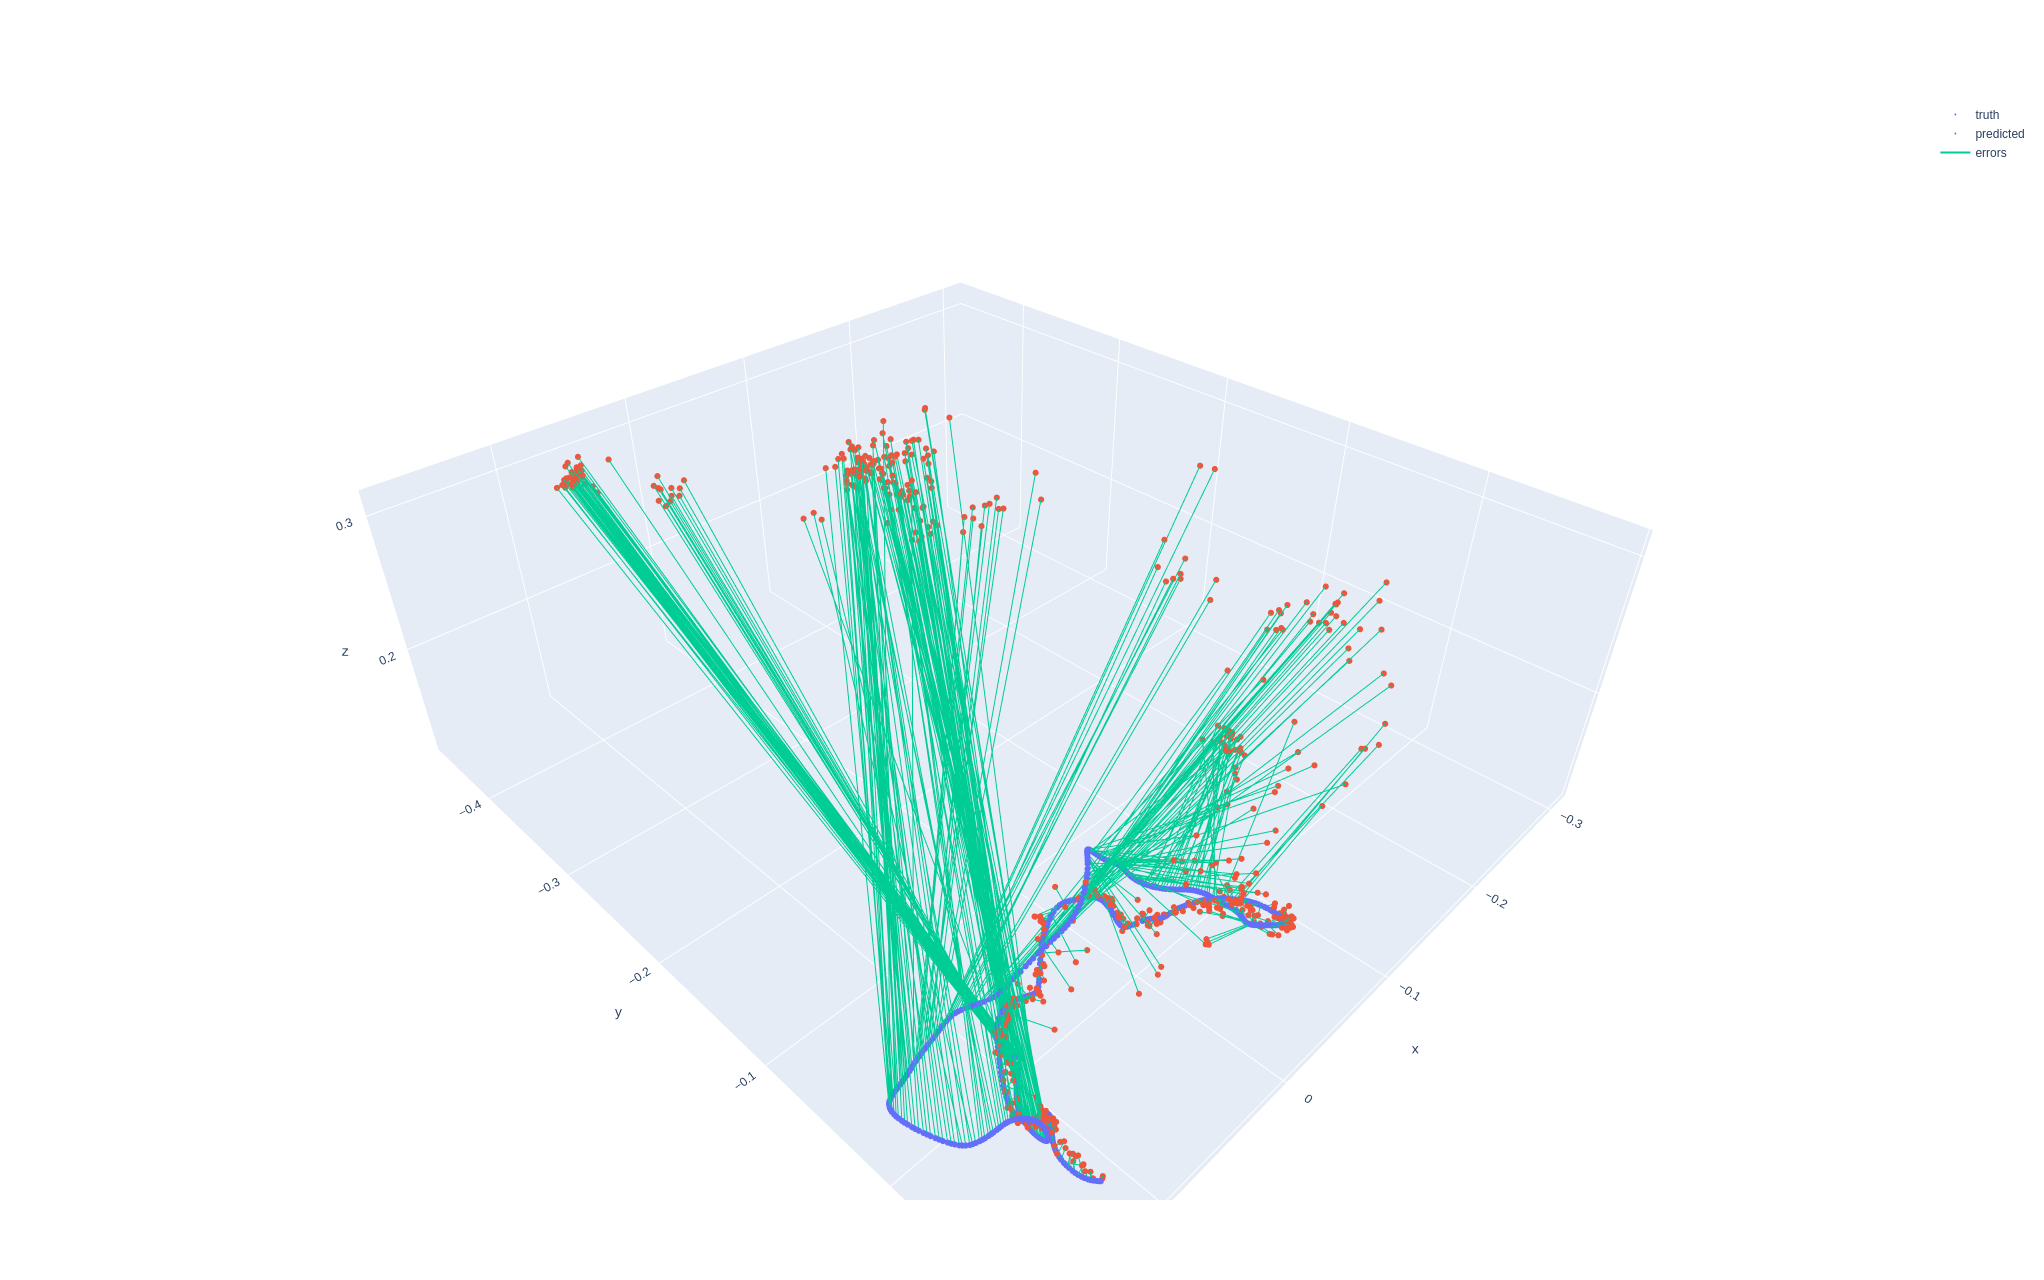

In [17]:
plot_trajectories(np.array(gt_poses)[:, 3, :3], np.array(poses)[:, 3, :3])
